# **Прогнозирование оттока клиентов из банка**
Из «Бета-Банка» каждый месяц стали уходить клиенты. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых. 

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Нам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком.

**Источник данных:** https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling

**Цель проекта:** построить модель с предельно большим значением F1-меры.

**План действий:**
откроем данные и изучим общую информацию
выполним предобработку
подготовим признаки для машинного обучения
исследуем баланс классов
попробуем разные техники борьбы с дисбалансом
протестируем лучшую выявленную модель

**Подготовка данных**

In [1]:
import pandas as pd

In [5]:
data = pd.read_csv('Churn.csv')

data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


Входные данные представляют собой таблицу, в которой каждая строка - наблюдение за одним из клиентов банка по 14 признакам.

**Признаки:**

RowNumber — индекс строки в данных
CustomerId — уникальный идентификатор клиента
Surname — фамилия
CreditScore — кредитный рейтинг
Geography — страна проживания
Gender — пол
Age — возраст
Tenure — сколько лет человек является клиентом банка
Balance — баланс на счёте
NumOfProducts — количество продуктов банка, используемых клиентом
HasCrCard — наличие кредитной карты
IsActiveMember — активность клиента
EstimatedSalary — предполагаемая зарплата
Целевой признак:

**Exited** — факт ухода клиента

# **Удаление ненужных столбцов**

В таблице есть два столбца, которые не несут никакой полезной информации для модели: RowNumber просто дублирует индекс строки, CustomerId и Surname - по сути по-разному записанные имена клиентов, уж точно никак не влияют на уход клиента из банка. Поэтому удалим эти столбцы.

In [6]:
data = data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


**Замена пропусков**

В столбце Tenure присутствуют пропуски. Их около 10%, поэтому удаление такой части данных будет неразумно. Заменим пропуски медианой. Такой подход учитывает имеющиеся данные и усредняет их.

In [7]:
data['Tenure'] = data['Tenure'].fillna(data['Tenure'].median())
#заодно приведем столбец к более читаемому виду
data['Tenure'] = data['Tenure'].astype('int')

#проверим, что пропусков не осталось
data['Tenure'].isna().sum()

0

**Проверка на выбросы**

В количественных признаках возможно существуют выбросы. Их точно стоит проверить. Для этого посмотрим общую информацию о признаках и их распределения.

In [8]:
quantitative = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

data.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


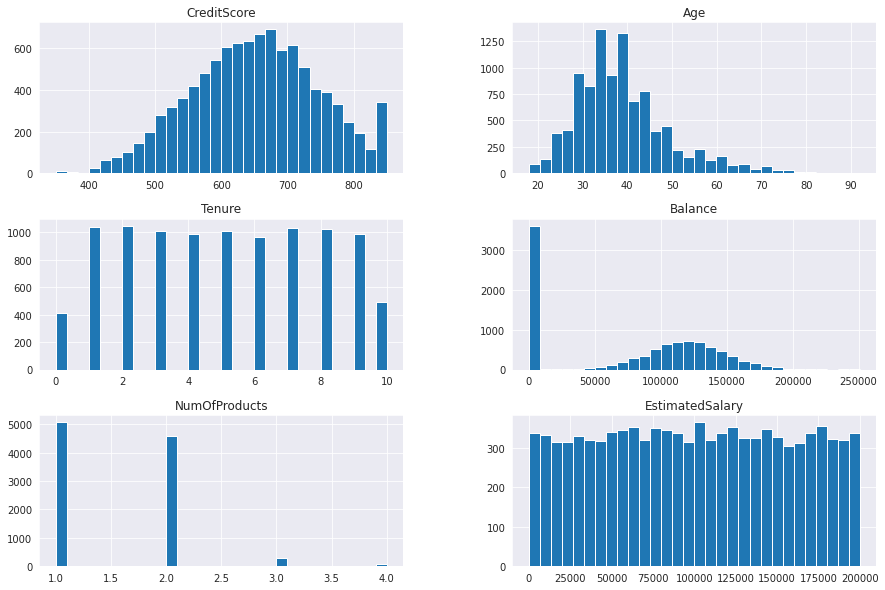

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')

clm = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
data[clm].hist(bins=30, figsize=(15, 10))
plt.show()

В целом все значения в пределах разумного.

По возрасту: самому младшему кллиенту 18, а значит он совершеннолетний и уже может пользоваться услугами банка. Самому старшему - 92, это не выходит за рамки возможного.

Баланс на счете вообще распределен нормально, не учитывая пика в нуле. В данной задаче это не похоже на выброс. Так как нулевой баланс может быть сигналом, что человек вскоре перестанет пользоваться услугами банка.

Во всех остальных признаках тоже нет аномальных значений. А значит выбросы в данны отсутствуют


**Прямое кодирование OHE**

Так как многие алгоритмы машинного обучение не умеют работать с объектами типа object, то преобразуем подобные столбцы в нашей таблице техникой прямого кодирования.


In [10]:
categorial = ['Geography', 'Gender']
#укажем параметр drop_first=True, чтобы не перегружать модель лишним столбцом
data = pd.get_dummies(data, columns=categorial, drop_first=True)
#посмотрим на новые столбцы
data.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0


**Корреляция признаков**

Сильно коррелирующие между собой признаки будут усложнять обучение модели. Проверим как коррелируеют признаки.

In [11]:
data.corr()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
CreditScore,1.000000,-0.003965,0.000842,0.006268,0.012238,-0.005458,0.025651,-0.001384,-0.027094,0.005538,0.004780,-0.002857
Age,-0.003965,1.000000,-0.009997,0.028308,-0.030680,-0.011721,0.085472,-0.007201,0.285323,0.046897,-0.001685,-0.027544
Tenure,0.000842,-0.009997,1.000000,-0.012254,0.013444,0.022583,-0.028362,0.007784,-0.014001,-0.000567,0.003868,0.014733
Balance,0.006268,0.028308,-0.012254,1.000000,-0.304180,-0.014858,-0.010084,0.012797,0.118533,0.401110,-0.134892,0.012087
NumOfProducts,0.012238,-0.030680,0.013444,-0.304180,1.000000,0.003183,0.009612,0.014204,-0.047820,-0.010419,0.009039,-0.021859
HasCrCard,-0.005458,-0.011721,0.022583,-0.014858,0.003183,1.000000,-0.011866,-0.009933,-0.007138,0.010577,-0.013480,0.005766
IsActiveMember,0.025651,0.085472,-0.028362,-0.010084,0.009612,-0.011866,1.000000,-0.011421,-0.156128,-0.020486,0.016732,0.022544
EstimatedSalary,-0.001384,-0.007201,0.007784,0.012797,0.014204,-0.009933,-0.011421,1.000000,0.012097,0.010297,-0.006482,-0.008112
Exited,-0.027094,0.285323,-0.014001,0.118533,-0.047820,-0.007138,-0.156128,0.012097,1.000000,0.173488,-0.052667,-0.106512
Geography_Germany,0.005538,0.046897,-0.000567,0.401110,-0.010419,0.010577,-0.020486,0.010297,0.173488,1.000000,-0.332084,-0.024628


Максимальная корреляция достигает 0.4 . Это очень слабый показатель поэтому мы оставляем все признаки.

**Разделение данных**

Разделим данные на обучающую, валидационную и тестовые выборки.

In [12]:
from sklearn.model_selection import train_test_split

#разделим в пропорции 60:20:20
train, other = train_test_split(data, test_size=0.4, random_state=5, stratify=data['Exited'])
valid, test = train_test_split(other, test_size=0.5, random_state=5, stratify=other['Exited'])

features_train = train.drop('Exited', axis=1)
target_train = train['Exited']

features_valid = valid.drop('Exited', axis=1)
target_valid = valid['Exited']

features_test = test.drop('Exited', axis=1)
target_test = test['Exited']

**Стандартизация данных**

В исследовании мы будем использовать модель логистической регресси, которая, в отличие от деревьев, чувствительна к разным масштабам количественных признаков - она может посчитать какие-то признаки более весомее, чем другие. Чтобы избежать подобного, стандартизируем данные.

In [13]:
from sklearn.preprocessing import StandardScaler
pd.options.mode.chained_assignment=None

#выделим количественные признаки
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

scaler = StandardScaler()
#обучим на тренировочных данных
scaler.fit(features_train[numeric])
#стандартизируем численные признаки в признаках для обучения
features_train[numeric] = scaler.transform(features_train[numeric])

#сразу же стандартизируем и признаки валидационной и тестовой выборок
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

**Вывод:**

Нами были прочитаны данные и краткая информация о них. Затем подготовили данные для обучения моделей:



*   удалили ненужные столбцы
*заполнили пропуски
*проверили на выбросы
*преобразовали данные в понятный для алгоритма формат
*убедились, что нет сильно коррелирующих признаков
разделили данные на обучающую, валидационую и тестовую выборки


Мы никак не обрабатывали столбцы HasCrCard и IsActiveMember. Данные в них представленны уже в удовлетворительном бинарном виде.

# **Исследование задачи**

**Проверка баланса классов**

In [14]:
target_train.value_counts(normalize=True)

0    0.796333
1    0.203667
Name: Exited, dtype: float64

Результат показал, что классы находятся в дисбалансе.

Посмотрим какие будут метрики качества, если оставить дисбаланс.

Будем использовать три алгоритма машинного обучения: решающее дерево, случаный лес и логиситческую регрессию. Для сравнения моделей будем использовать две метрики качества: F1-меру и AUC-ROC.

**Решающее дерево**

In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

best_f1 = 0
#перебором найдем лучшую глубину дерева и выведем результат на экран
for depth in range(2, 20):
    model = DecisionTreeClassifier(max_depth=depth, random_state=5)
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    
    #посчитаем значение F1меры
    f1 = f1_score(y_true = target_valid, y_pred = predictions)
    
    #теперь узнаем AUC-ROC: сначала посчитаем вероятности классов
    proba = model.predict_proba(features_valid)
    #выделим из них положительные 
    proba_one = proba[:, 1]
    #и посчитаем саму метрику 
    auc_roc = roc_auc_score(target_valid, proba_one)
    if f1 > best_f1:
        best_f1 = f1
        best_depth = depth
        best_auc_roc = auc_roc

print('Лучший результат F1 =', best_f1, '| глубина =', best_depth, '| AUC-ROC =', best_auc_roc)

Лучший результат F1 = 0.5735735735735736 | глубина = 8 | AUC-ROC = 0.8341785545175375


**Случайный лес**

In [16]:
from sklearn.ensemble import RandomForestClassifier

best_f1 = 0
#циклом переберем гипермапареметры: количество решающих деревьев и глубину дерева, выведем параметры модели с лучшим результатом
for estim in range(10, 111, 5):
    for depth in range(5, 16):
        model = RandomForestClassifier(n_estimators=estim, max_depth=depth, random_state=5)
        model.fit(features_train, target_train)
        predictions = model.predict(features_valid)
        
        f1 = f1_score(y_true = target_valid, y_pred = predictions)
        
        proba = model.predict_proba(features_valid)
        proba_one = proba[:, 1]
        auc_roc = roc_auc_score(target_valid, proba_one)
        if f1 > best_f1:
            best_f1 = f1
            best_depth = depth
            best_estim = estim
            best_auc_roc = auc_roc
            
print('Лучший результат F1 =', best_f1, '| количество деревьев =', best_estim, '| глубина =', best_depth,
      '| AUC-ROC =', best_auc_roc)

Лучший результат F1 = 0.5803432137285491 | количество деревьев = 20 | глубина = 11 | AUC-ROC = 0.8560062373621696


**Логистическая регрессия**

In [17]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='liblinear', random_state=5)
model.fit(features_train, target_train)
predictions = model.predict(features_valid)

f1 = f1_score(y_true = target_valid, y_pred = predictions)

proba = model.predict_proba(features_valid)
proba_one = proba[:, 1]
auc_roc = roc_auc_score(target_valid, proba_one)

print('F1 =', f1, '| AUC-ROC =', auc_roc)

F1 = 0.29259259259259257 | AUC-ROC = 0.7773196925739299


**Вывод:**

Мы выявили, что классы целевого признака находятся в дисбалансе - соотношение 8:2.

Не изменяя баланса классов, мы протестировали на данных три вида алгоритмов машинного обучения: решающее дерево, случаный лес и логиситческую регрессию. Для решающего девера и случайного леса подобрали лучшие гиперпараметры. После вычислили значения метрик качества F1 и AUC-ROC.

Каждая модель работает лучше чем случайная.

**Лучшей моделью оказалась модель случаного леса с гиперпараметрами: количество деревьев = 90 и глубина = 13. Её метрики качества получились: F1 = 0.588, AUC-ROC = 0.84.**

Немного хуже справилась модель решающего дерева: F1 = 0.571 | AUC-ROC = 0.83. Хуже всех показала себя логистическая регрессия: F1 = 0.293 | AUC-ROC = 0.78.

# **Борьба с дисбалансом**

Для упрощения работы напишем три функции, которые будут возвращать нам модели с лучшими результатами для каждого из выбранных алгоритмов.

In [18]:
def tree_results(features_train, target_train, features_valid, target_valid, clas_weight):
    '''
    функция подбора лучших гиперпараметров для алгоритма решающего дерева
    функция перебирает разные глубины дерева решений и возвращает лучшую модель по метрике f1,
    дополнительно возвращает параметры и AUC-ROC
    '''
    best_f1 = 0
    for depth in range(1, 20):
        model = DecisionTreeClassifier(max_depth=depth, random_state=5, class_weight=clas_weight)
        model.fit(features_train, target_train)
        predictions = model.predict(features_valid)
        
        f1 = f1_score(y_true = target_valid, y_pred = predictions)
        
        proba = model.predict_proba(features_valid)
        proba_one = proba[:, 1]
        auc_roc = roc_auc_score(target_valid, proba_one)
        if f1 > best_f1:
            best_f1 = f1
            best_depth = depth
            best_auc_roc = auc_roc
    print('ДЕРЕВО РЕШЕНИЙ          | F1 =', best_f1, '| AUC-ROC =', best_auc_roc, '| глубина =', best_depth)
#-----------------------------------------------------------------------------------------------------------------------
def forest_results(features_train, target_train, features_valid, target_valid, clas_weight):
    '''
    функция подбора лучших гиперпараметров для алгоритма случайного леса
    функция перебирает разные глубины дерева решений и количества решающих деревьев, и возвращает лучшую модель по метрике f1,
    дополнительно возвращает параметры модели и AUC-ROC
    '''
    best_f1 = 0
    for estim in range(30, 111, 5):
        for depth in range(5, 16):
            model = RandomForestClassifier(n_estimators=estim, max_depth=depth, random_state=5, class_weight=clas_weight)
            model.fit(features_train, target_train)
            predictions = model.predict(features_valid)
            
            f1 = f1_score(y_true = target_valid, y_pred = predictions)
            
            proba = model.predict_proba(features_valid)
            proba_one = proba[:, 1]
            auc_roc = roc_auc_score(target_valid, proba_one)
            if f1 > best_f1:
                best_f1 = f1
                best_depth = depth
                best_estim = estim
                best_auc_roc = auc_roc      
    print('СЛУЧАЙНЫЙ ЛЕС           | F1 =', best_f1, '| AUC-ROC =', best_auc_roc,
          '| количество деревьев =', best_estim, '| глубина =', best_depth)
#-----------------------------------------------------------------------------------------------------------------------
def logreg_results(features_train, target_train, features_valid, target_valid, clas_weight):
    '''
    функция возвращает результаты f1 и AUC-ROC для модели обученной с помощью логистической регрессии
    '''
    model = LogisticRegression(solver='liblinear', random_state=5, class_weight=clas_weight)
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    
    f1 = f1_score(y_true = target_valid, y_pred = predictions)
    
    proba = model.predict_proba(features_valid)
    proba_one = proba[:, 1]
    auc_roc = roc_auc_score(target_valid, proba_one)

    print('ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ | F1 =', f1, '| AUC-ROC =', auc_roc)

**Взвешивание классов**

Сначала попробуем способ, который рассчитает и сам установит веса классов, тем самым сбалансируя их. Для этого будем указывать class_weight='balanced' при создании каждой модели.

In [19]:
tree_results(features_train, target_train, features_valid, target_valid, 'balanced')
forest_results(features_train, target_train, features_valid, target_valid, 'balanced')
logreg_results(features_train, target_train, features_valid, target_valid, 'balanced')

ДЕРЕВО РЕШЕНИЙ          | F1 = 0.591937069813176 | AUC-ROC = 0.8309573055335767 | глубина = 7
СЛУЧАЙНЫЙ ЛЕС           | F1 = 0.6270136307311028 | AUC-ROC = 0.8622536249654895 | количество деревьев = 65 | глубина = 10
ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ | F1 = 0.5077062556663645 | AUC-ROC = 0.7788913721117111


Данным способом нам удалось значительно увеличить показатели качества. Фаворитом все так же остается случайный лес, его F1-мера возросла на приблизительно на 5% по сравнению с результатами без балансировки.

**Upsampling**

Теперь попробуем технику увеличения выборки. Увеличим количество положительных ответов настолько, чтобы приблизительно сравнять его с количеством отрицательными.

In [20]:
from sklearn.utils import shuffle

#сначала разделим положительные и отрицательные ответы
features_zeros = features_train[target_train == 0]
features_ones = features_train[target_train == 1]
target_zeros = target_train[target_train == 0]
target_ones = target_train[target_train == 1]

#здесь посчитаем во сколько раз нужно увеличить положительные ответы и
#окргулим в большую сторону, потому что датафреймы можно умножать только на целые числа
repeat = round((len(features_zeros) / len(features_ones)))

#в новые переменные поместим ( [все отрицательные] + [все положительные] * на нужное для уравнения количество раз)
features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat )
target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat ) 

#перемешаем объекты, чтобы модель лучше обучалась
features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=5)

Найдем лучшие модели для данных, преобразованных техникой upsampling.

In [21]:
tree_results(features_upsampled, target_upsampled, features_valid, target_valid, None)
forest_results(features_upsampled, target_upsampled, features_valid, target_valid, None)
logreg_results(features_upsampled, target_upsampled, features_valid, target_valid, None)

ДЕРЕВО РЕШЕНИЙ          | F1 = 0.5911330049261083 | AUC-ROC = 0.8291041426634647 | глубина = 7
СЛУЧАЙНЫЙ ЛЕС           | F1 = 0.6378504672897196 | AUC-ROC = 0.8554448130719318 | количество деревьев = 30 | глубина = 11
ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ | F1 = 0.5080500894454383 | AUC-ROC = 0.7789145077280669


Результаты так же лучше чем без балансировки. Также подросли метрики качества по сравнению с методом взвешивания классов.

**Downsampling**

Попробуем еще одну похожую технику. Суть ее заключается в уменьшении количества объектов большего класса настолько, чтобы их количество приблизительно сравнялось с меньшим классом.

In [22]:
from sklearn.utils import shuffle

#посчитаем какую часть данных нужно оставить
fraction = len(features_ones) / len(features_zeros)

#объединим положительные ответы с нужной частью отрицательных
features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=5)] + [features_ones])
target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=5)] + [target_ones])

#также перемешаем
features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state=5)

Найдем лучшие модели для данных, преобразованных техникой downsampling.

In [23]:
tree_results(features_downsampled, target_downsampled, features_valid, target_valid, None)
forest_results(features_downsampled, target_downsampled, features_valid, target_valid, None)
logreg_results(features_downsampled, target_downsampled, features_valid, target_valid, None)

ДЕРЕВО РЕШЕНИЙ          | F1 = 0.5796460176991151 | AUC-ROC = 0.813698135732034 | глубина = 5
СЛУЧАЙНЫЙ ЛЕС           | F1 = 0.6186612576064908 | AUC-ROC = 0.8625327947361845 | количество деревьев = 100 | глубина = 9
ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ | F1 = 0.5031674208144796 | AUC-ROC = 0.777153116136167


Результаты все так же лучше, чем без балансировки. Но данная техника борьбы с дисбалансом показала себя немного хуже, нежели две предыдущие.

**Вывод**

С целью решения проблемы дисбаланса классов целевого признака мы попробовали три техники: взвешивание классов, upsampling и downsampling. Применяя каждую технику, мы нашли результаты метрик качества для трех лучших моделей, обученных разными алгоритмами.

Каждая модель работает лучше случайной.

Но лучший результат был достигнут с помощью **техники upsampling у модели случайного леса с гиперпараметрами: количество деревьев = 65 | глубина = 10. Метрики качества: F1 = 0.6339 , AUC-ROC = 0.8615.**

# **Тестирование модели**

Осталось лишь протестировать выявленную лучшую модель на тестовых данных.

In [24]:
model = RandomForestClassifier(n_estimators=65, max_depth=10, random_state=5)
model.fit(features_upsampled, target_upsampled)
predictions = model.predict(features_test)

f1 = f1_score(y_true = target_test, y_pred = predictions)

proba = model.predict_proba(features_test)
proba_one = proba[:, 1]
auc_roc = roc_auc_score(target_test, proba_one)

print('F1 =', f1, '| AUC-ROC =', auc_roc)

F1 = 0.6062639821029082 | AUC-ROC = 0.8628451694748253


# **Общий вывод:**

Входные данные представляли собой таблицу, в которой каждый объект представлял собой наблюдение за одинм клиентом банка по 14-ти признакам.

Данные были преобработаны и подготовлены для обучения на трех алгоритмах машинного обучения: решающее дерево, случаный лес и логиситческая регрессия.

Было выявленно, что классы целевого признака находятся в дисбалансе. Сначала мы попробовали решить задачу без учета дисбаланса, но, не получив нужных результатов по метрикам качества, было принято решение сбалансировать классы.

Балансировка осуществлялась тремя техниками: взвешиванием классов, upsampling и downsampling. Для каждой из техник были выявлены лучшие модели по выбранным алгоритмам.

Лучше всех себя показала **модель случайного леса с гиперпараметрами: количество деревьев = 65 | глубина = 10, которая была обучена на данных, сбаласированных техникой upsampling.**

На тестовой выборке данная модель показала результаты: **F1 = 0.605 и AUC-ROC = 0.869.**